In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.ticker import FixedLocator, FuncFormatter



read in CSV which contains visit_occurrences for all those who received mechanical ventilation


In [3]:
df_vac = pd.read_csv(
    '/Users/matthewwillis/Local Dev/ESICM_datathon/vented_totals.csv')

df_vac.columns

Index(['Unnamed: 0', 'visit_occurrence_id', 'measurement_concept_id',
       'measurement_datetime', 'measurement_type_concept_id',
       'value_as_number', 'unit_concept_id', 'provider_id'],
      dtype='object')

dictionary of concept_ids for data extraction purposes


In [4]:
concept_ids = {
    "fio2": 3020716,
    "eMV": 42527120,
    "iMV": 42527121,
    "PEEP": 21490855,
    "Cdyn": 21490582,
    "Cstat": 21490583,
    "mean airway pressure": 42527086,
    "Pplat": 44782825,
    "ETCO2": 3035357,
    "pCO2": 3013290,
    "pO2": 3027315
}

drop columns not required for analysis and rename value_as_number to fio2 for clarity, sort data in occurrence and datetime order, reset the index


In [53]:
df_fio2 = df_vac[df_vac['measurement_concept_id'] == concept_ids['fio2']].drop(
    [
        'Unnamed: 0', 'unit_concept_id', 'provider_id',
        'measurement_concept_id', 'measurement_type_concept_id'
    ],
    axis=1).sort_values(['visit_occurrence_id', 'measurement_datetime'])

df_fio2.rename(columns={'value_as_number': 'fio2'}, inplace=True)

df_fio2.reset_index(drop=True, inplace=True)

df_fio2.head(10)

,visit_occurrence_id,measurement_datetime,fio2
0,12,2006-01-01 00:15:00+00:00,22.0
1,12,2006-01-01 01:15:00+00:00,49.0
2,12,2006-01-01 02:15:00+00:00,40.0
3,12,2006-01-01 03:15:00+00:00,39.0
4,12,2006-01-01 04:15:00+00:00,39.0
5,12,2006-01-01 05:15:00+00:00,39.0
6,12,2006-01-01 06:15:00+00:00,40.0
7,12,2006-01-01 07:15:00+00:00,40.0
8,12,2006-01-01 08:15:00+00:00,98.0
9,12,2006-01-01 09:15:00+00:00,70.0


get patients ventilated for 4 days or more

In [56]:
df_fio2['measurement_datetime'] = pd.to_datetime(
    df_fio2['measurement_datetime'])

df_grouped_duration = df_fio2.groupby('visit_occurrence_id').agg(
    {'measurement_datetime': ['max', 'min']})

df_grouped_duration['duration'] = df_grouped_duration['measurement_datetime'][
    'max'] - df_grouped_duration['measurement_datetime']['min']

vent_dur4_idx = list(df_grouped_duration[df_grouped_duration['duration'] >= pd.Timedelta(4, "d")].index)

vent_dur4_idx

df_fio2 = df_fio2[df_fio2['visit_occurrence_id'].isin(vent_dur4_idx)]


total number ventilated


In [57]:
df_fio2.loc[:, 'visit_occurrence_id'].unique().shape

(172,)

group data by occurrence_id and hourly intervals

In [7]:
#ensure datetime column is correct datatype

df_fio2['measurement_datetime'] = pd.to_datetime(
    df_fio2['measurement_datetime'])

#summary stats by hour per patient occurrence

df_fio2_grouped = df_fio2.groupby(
    ['visit_occurrence_id',
     pd.Grouper(key='measurement_datetime',
                freq='h')]).agg({'fio2': ['max', 'min', 'count']})

df_fio2_grouped


fio2            
                                                max   min count
visit_occurrence_id measurement_datetime                       
12                  2006-01-01 00:00:00+00:00  22.0  22.0     1
                    2006-01-01 01:00:00+00:00  49.0  49.0     1
                    2006-01-01 02:00:00+00:00  40.0  40.0     1
                    2006-01-01 03:00:00+00:00  39.0  39.0     1
                    2006-01-01 04:00:00+00:00  39.0  39.0     1
...                                             ...   ...   ...
23506               2006-01-01 03:00:00+00:00  40.0  40.0     1
                    2006-01-01 04:00:00+00:00  40.0  40.0     1
                    2006-01-01 05:00:00+00:00  40.0  40.0     2
                    2006-01-01 06:00:00+00:00  40.0  40.0     1
                    2006-01-01 07:00:00+00:00  40.0  40.0     1

[74935 rows x 3 columns]

graphically assess O2 requirement during visit - change value of occ_id and run cell


<Axes: title={'center': 'Change in FiO2 during Admission Time'}, xlabel='date and time of measurement', ylabel='percentage of inspired oxygen'>

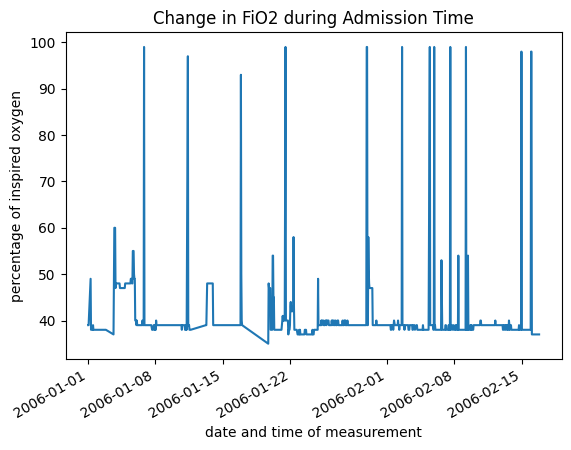

In [58]:
# change occ_id here
occ_id = 723

df_flattened = df_fio2_grouped.reset_index(inplace=False)

df_flattened

df_flattened[df_flattened['visit_occurrence_id'] == occ_id].plot(
    x='measurement_datetime',
    xlabel='date and time of measurement',
    y=('fio2', 'min'),
    ylabel="percentage of inspired oxygen",
    title="Change in FiO2 during Admission Time",
    legend=False)

to find those that meet VAC criteria based on FIO2:

- group all occurrences by occurrence_id and calculate the cumulative difference between all FiO2 readings for that occurrence
- then group y occurrence and hourly interval and get the max fio2 per hour (usually 1 reading anyway)
- reset index and aggreggate again this time by day and sum the cumulative difference find all those whose sum of the cumulative difference is > 20 between days 


In [68]:
df_occ_groups = df_fio2.sort_values(
    ['visit_occurrence_id', 'measurement_datetime'])

df_occ_groups.reset_index(inplace=False)

df_occ_groups['cumdiff'] = df_occ_groups.groupby(
    'visit_occurrence_id').diff()['fio2']

df_occ_groups.reset_index(inplace=False)

df_occ_groups

df_hourly_groups = df_occ_groups.groupby(
    ['visit_occurrence_id',
     pd.Grouper(key='measurement_datetime', freq='h')])

df_daily_groups = df_hourly_groups.max().reset_index(inplace=False)

df_daily_groups = df_daily_groups.groupby(
    ['visit_occurrence_id',
     pd.Grouper(key='measurement_datetime', freq='D')]).agg({
         'fio2': ['max', 'min', 'mean'],
         'cumdiff':
         'sum'
     })

unique_ids = [
    df_daily_groups[df_daily_groups['cumdiff']['sum'] > 20].index[id][0]
    for id in range(
        0, len(df_daily_groups[df_daily_groups['cumdiff']['sum'] > 20].index))
]

unique_ids = list(set(unique_ids))

s = pd.DataFrame(unique_ids)

s.to_csv("/Users/matthewwillis/Local Dev/ESICM_datathon/fio2_vac_candidates.csv")

assess graphically in notebook

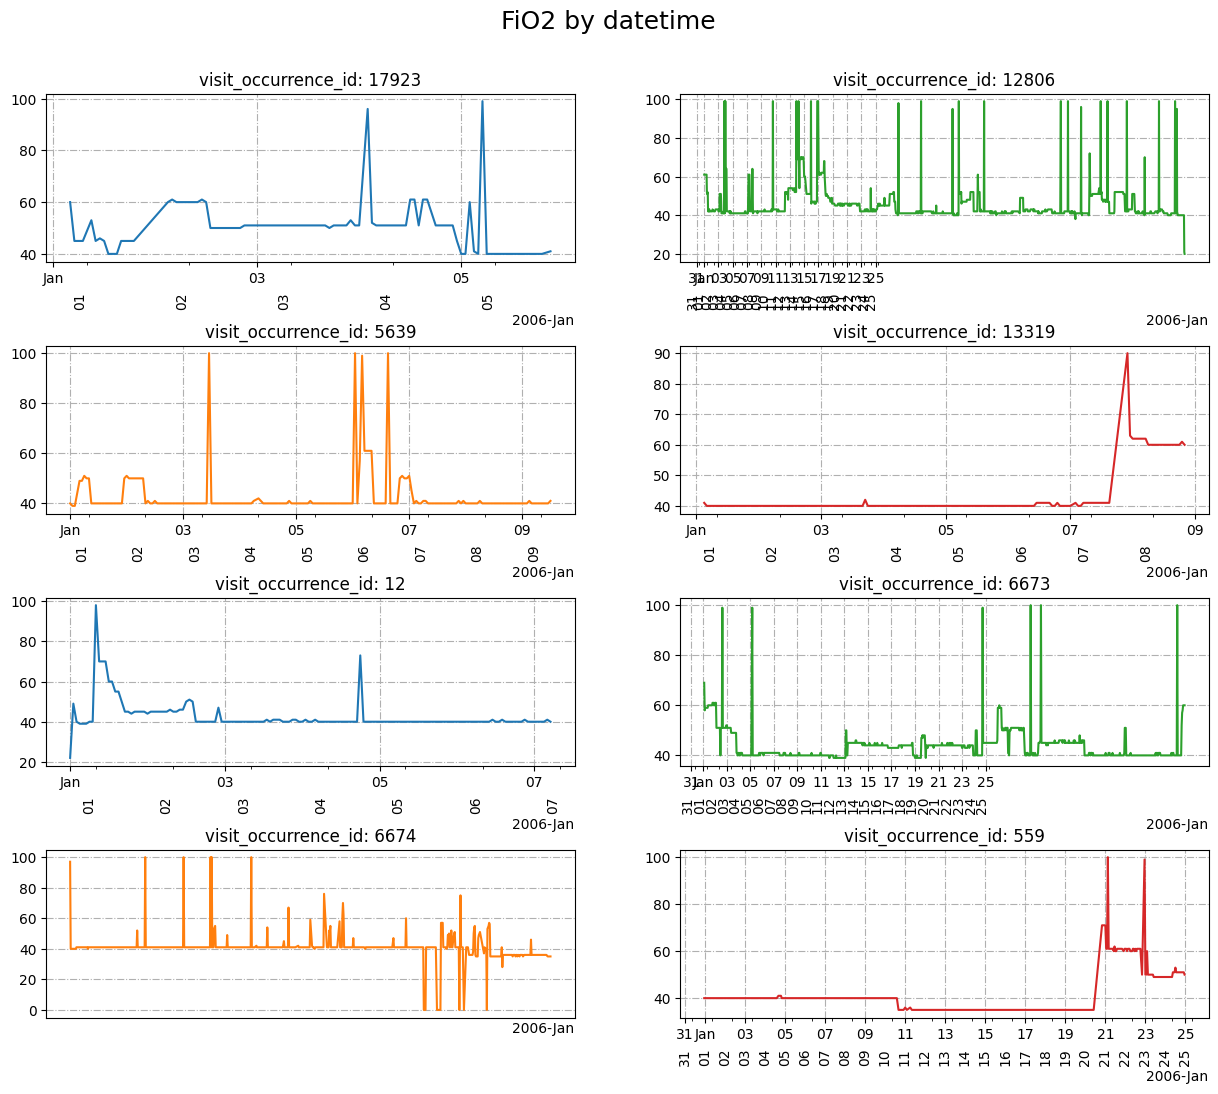

In [61]:
fig_colors = [
    'tab:blue',
    'tab:green',
    'tab:orange',
    'tab:red',
]

locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)

minor_locator = mdates.HourLocator(interval=24)
minor_formatter = mdates.DateFormatter('%d')

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("FiO2 by datetime", fontsize=18, y=0.95)

for n, id in enumerate(unique_ids[0:8]):
   ax = plt.subplot(4, 2, n + 1)

   x = df_flattened[df_flattened['visit_occurrence_id'] == id]['measurement_datetime']

   y = df_flattened[df_flattened['visit_occurrence_id'] == id]['fio2']['max']

   ax.plot(x, y, fig_colors[(n % 4)])
   
   ax.set_title(f'visit_occurrence_id: {id}')

   ax.grid(True, linestyle='-.')

   ax.xaxis.set_major_locator(locator)
   ax.xaxis.set_major_formatter(formatter)
   ax.xaxis.set_minor_locator(minor_locator)
   ax.xaxis.set_minor_formatter(minor_formatter)

   for label in ax.get_xticklabels(which='minor'):
      label.set_rotation(90)
      label.set_horizontalalignment('right')

   ax.tick_params(axis='x', which='minor', pad=20)


create PDF with all patients with potential VAC for visual assessment

In [62]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('/Users/matthewwillis/Local Dev/ESICM_datathon/FiO2.pdf')

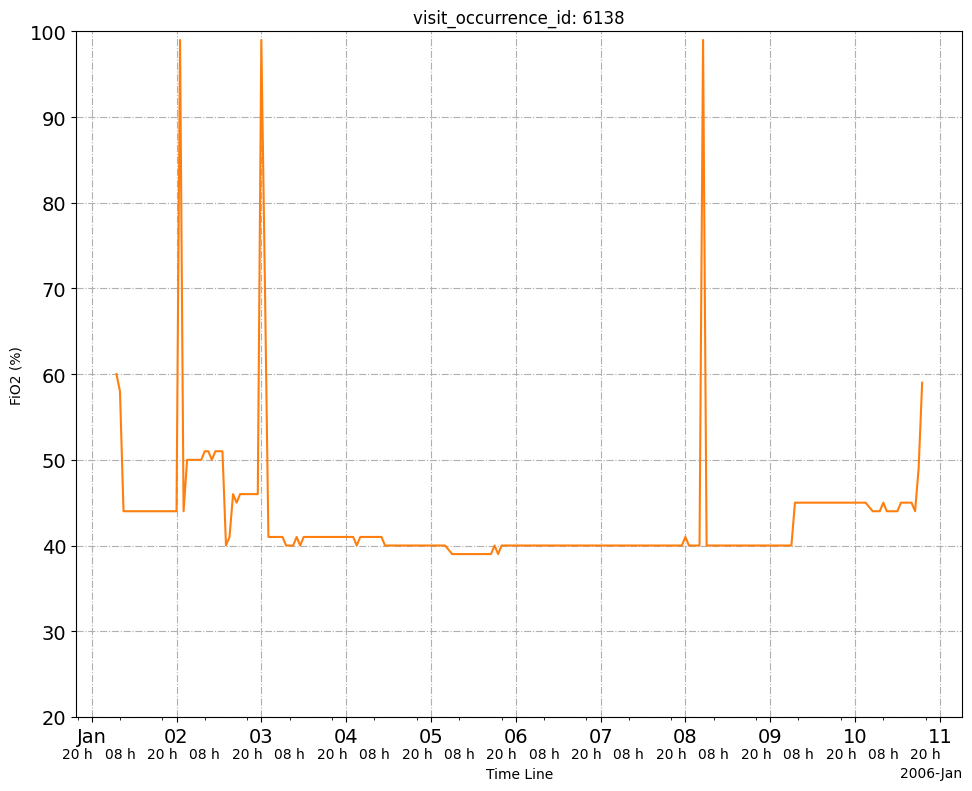

In [63]:
id_list_size = len(unique_ids) - 1

for n, id in enumerate(unique_ids[0:id_list_size]):

   fig_colors = [
      'tab:blue',
      'tab:green',
      'tab:orange',
      'tab:red',
   ]

   plt.close()

   w, h = 8.27, 11.69
   margin = 1

   locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
   formatter = mdates.ConciseDateFormatter(locator)

   minor_locator = mdates.HourLocator(interval=12)
   minor_formatter = mdates.DateFormatter('%H h')

   x = df_flattened[df_flattened['visit_occurrence_id'] ==
                  id]['measurement_datetime']

   y = df_flattened[df_flattened['visit_occurrence_id'] == id]['fio2']['max']

   fig = plt.figure(figsize=(h,w), dpi=100)

   ax = fig.add_axes([margin / w, margin / h, (w - 2 * margin) / w, (h - 2 * margin) / h])

   ax.set_title(f'visit_occurrence_id: {id}')

   ax.grid(True, linestyle='-.')

   ax.xaxis.set_major_locator(locator)
   ax.xaxis.set_major_formatter(formatter)
   ax.xaxis.set_minor_locator(minor_locator)
   ax.xaxis.set_minor_formatter(minor_formatter)

   ax.tick_params(axis='x', which='minor', pad=20, labelsize=10)
   ax.tick_params(which='major', labelsize=14)

   for label in ax.get_xticklabels(which='minor'):
      label.set_rotation(45)

   ax.set_title(f'visit_occurrence_id: {id}')
   ax.set_xlabel('Time Line')
   ax.set_ylabel('FiO2 (%)')

   ax.set_ylim(20, 100)

   ax.plot(x, y, fig_colors[n % 4])

   pdf.savefig(fig)



pdf.close()
